# Fashion mnist experiments

In [46]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
import sys
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

# Log events in realtime
import tensorboard_logger as tfl

# Set logging directory
logdir = os.path.join(os.getcwd(), "logs")
if not os.path.exists(logdir):
    os.makedirs(logdir)

# Check if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
def plot_history_acc(
        history,
        ylims=None,
        xlims=None,
):
    plt.figure(figsize=(12, 6))
    for phase in ('train', 'val'):
        plt.plot(history[phase]['acc'], label=phase)
    plt.legend()
    if xlims is not None:
        plt.xlim(xlims)
    if ylims is None:
        plt.ylim([0.84, 0.94])
    else:
        plt.ylim(ylims)
    plt.title('Train + validation '\
              'accuracy on Fashion MNIST')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()
    return

In [56]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()

    # Keep track of histories
    history = {
        'train': {
            'loss': [],
            'acc': []
        },
        'val': {
            'loss': [],
            'acc': []
        }
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Let's log train+val accuracy
            logger.log_value(phase + '_acc', epoch_acc, epoch)

            for metric, loss in zip(('loss', 'acc'), (epoch_loss, epoch_acc)):
                history[phase][metric].append(loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss,
                                                       epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Keep last model weights in case we wish to
    # continue training
    last_model_wts = copy.deepcopy(model.state_dict())

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, history, last_model_wts

## Data processing block

In [74]:
batch_size = 100

In [75]:
data_transf = {
    'train':
    transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomCrop(28, padding=2),
        transforms.ToTensor(),
        #transforms.Normalize((0.1307,), (0.3081,))
        transforms.Normalize((0.5, ), (0.5, ))
    ]),
    'val':
    transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.1307,), (0.3081,))
        transforms.Normalize((0.5, ), (0.5, ))
    ]),
}

trainset = (datasets.FashionMNIST(
    "../data_fashion",
    train=True,
    download=True,
    transform=data_transf['train']))
testset = (datasets.FashionMNIST(
    "../data_fashion",
    train=False,
    download=True,
    transform=data_transf['val']))

image_datasets = {'train': trainset, 'val': testset}

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=4)

dataloaders = {'train': trainloader, 'val': testloader}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [121]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv_drop = True
        input_shape = 1
        output_shape = 10

        # conv params
        clayer1_ch = 64  #28#24
        clayer2_ch = 64  #28#24
        clayer3_ch = 64  #48#28
        clayer4_ch = 64  #48#32

        # fc params
        fc1_units = 512
        fc2_units = int(fc1_units // 2)

        # convolutional layers
        self.conv1 = nn.Conv2d(
            in_channels=input_shape,
            out_channels=clayer1_ch,
            kernel_size=3,
            padding=1,
            stride=1)
        self.bn1_2d = nn.BatchNorm2d(clayer1_ch)
        self.conv2 = nn.Conv2d(
            in_channels=clayer1_ch,
            out_channels=clayer2_ch,
            kernel_size=3,
            padding=1,
            stride=1)
        self.bn2_2d = nn.BatchNorm2d(clayer2_ch)
        self.conv3 = nn.Conv2d(
            in_channels=clayer2_ch,
            out_channels=clayer3_ch,
            kernel_size=3,
            padding=1,
            stride=1)
        self.bn3_2d = nn.BatchNorm2d(clayer3_ch)
        self.conv4 = nn.Conv2d(
            in_channels=clayer3_ch,
            out_channels=clayer4_ch,
            kernel_size=3,
            padding=1,
            stride=1)
        self.bn4_2d = nn.BatchNorm2d(clayer4_ch)

        # pooling
        self.pool = nn.MaxPool2d(2, 2)

        # dropout
        self.conv_dropout = nn.Dropout(0.2)
        self.dropout = nn.Dropout(0.3)

        # fully connected layers
        self.fc1 = nn.Linear(clayer4_ch * 7 * 7, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, output_shape)

        # batchnorm
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)

    def forward(self, x):

        ### Block 1
        x = F.relu(self.conv1(x))
        x = self.bn2_2d(F.relu(self.conv2(x)))
        if self.conv_drop:
            x = self.conv_dropout(x)
        x = self.pool(x)

        ### Block 2
        x = F.relu(self.conv3(x))
        x = self.bn4_2d(F.relu(self.conv4(x)))
        if self.conv_drop:
            x = self.conv_dropout(x)
        x = self.pool(x)

        ### Flatten
        x = x.view(-1, self.num_flat_features(x))

        ### Fully connected layers
        x = self.bn1(F.relu(self.fc1(x)))
        x = self.dropout(x)
        x = self.bn2(F.relu(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


# Add to GPU device
net = ConvNet().to(device)

# Check the number of parameters
pytorch_total_params = sum(
    p.numel() for p in net.parameters() if p.requires_grad)
print("Number of trainable params =", pytorch_total_params)

Number of trainable params = 1853514


## Set optimizer and learning rate scheduler in order to control learning

In [122]:
# First we specify metadata to tensorboard
rundesc = "conv__less-batchnorm__dropout-0.3__less-fc-units__batchsize-100__filters-64_64_64_64__convdrop-0.2"
rundir = os.path.join(logdir, rundesc)
if not os.path.exists(rundir):
    os.makedirs(rundir)
logger = tfl.Logger(rundir)

In [123]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized

###optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
###optimizer = optim.Adam(net.parameters(), lr=0.001)
optimizer = optim.Adadelta(net.parameters())

# Decay LR by a factor of 'gamma' every 'step_size' epochs
###scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)
###scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 150, eta_min=1e-4)

In [124]:
model, history, last_model_wts = train_model(
    net, criterion, optimizer, scheduler=None, num_epochs=200)

Epoch 1/200
----------
train Loss: 0.6076 Acc: 0.7748
val Loss: 0.4672 Acc: 0.8314

Epoch 2/200
----------
train Loss: 0.4301 Acc: 0.8426
val Loss: 0.3953 Acc: 0.8603

Epoch 3/200
----------
train Loss: 0.3742 Acc: 0.8626
val Loss: 0.3683 Acc: 0.8600

Epoch 4/200
----------
train Loss: 0.3480 Acc: 0.8744
val Loss: 0.3257 Acc: 0.8875

Epoch 5/200
----------
train Loss: 0.3283 Acc: 0.8807
val Loss: 0.3714 Acc: 0.8680

Epoch 6/200
----------
train Loss: 0.3159 Acc: 0.8860
val Loss: 0.4461 Acc: 0.8414

Epoch 7/200
----------
train Loss: 0.3008 Acc: 0.8912
val Loss: 0.3389 Acc: 0.8804

Epoch 8/200
----------
train Loss: 0.2924 Acc: 0.8932
val Loss: 0.3195 Acc: 0.8903

Epoch 9/200
----------
train Loss: 0.2818 Acc: 0.8970
val Loss: 0.2941 Acc: 0.8994

Epoch 10/200
----------
train Loss: 0.2765 Acc: 0.9007
val Loss: 0.2721 Acc: 0.9007

Epoch 11/200
----------
train Loss: 0.2730 Acc: 0.9015
val Loss: 0.2550 Acc: 0.9093

Epoch 12/200
----------
train Loss: 0.2674 Acc: 0.9035
val Loss: 0.2313 Ac

val Loss: 0.1796 Acc: 0.9381

Epoch 98/200
----------
train Loss: 0.1573 Acc: 0.9429
val Loss: 0.1717 Acc: 0.9421

Epoch 99/200
----------
train Loss: 0.1530 Acc: 0.9437
val Loss: 0.1750 Acc: 0.9396

Epoch 100/200
----------
train Loss: 0.1526 Acc: 0.9445
val Loss: 0.1748 Acc: 0.9378

Epoch 101/200
----------
train Loss: 0.1545 Acc: 0.9445
val Loss: 0.1967 Acc: 0.9395

Epoch 102/200
----------
train Loss: 0.1550 Acc: 0.9443
val Loss: 0.2026 Acc: 0.9410

Epoch 103/200
----------
train Loss: 0.1512 Acc: 0.9454
val Loss: 0.1847 Acc: 0.9389

Epoch 104/200
----------
train Loss: 0.1504 Acc: 0.9448
val Loss: 0.1851 Acc: 0.9340

Epoch 105/200
----------
train Loss: 0.1508 Acc: 0.9455
val Loss: 0.1721 Acc: 0.9392

Epoch 106/200
----------
train Loss: 0.1534 Acc: 0.9444
val Loss: 0.1834 Acc: 0.9376

Epoch 107/200
----------
train Loss: 0.1522 Acc: 0.9450
val Loss: 0.2095 Acc: 0.9419

Epoch 108/200
----------
train Loss: 0.1484 Acc: 0.9464
val Loss: 0.1719 Acc: 0.9395

Epoch 109/200
----------
t

train Loss: 0.1221 Acc: 0.9550
val Loss: 0.2101 Acc: 0.9369

Epoch 194/200
----------
train Loss: 0.1214 Acc: 0.9561
val Loss: 0.1885 Acc: 0.9396

Epoch 195/200
----------
train Loss: 0.1239 Acc: 0.9550
val Loss: 0.1710 Acc: 0.9464

Epoch 196/200
----------
train Loss: 0.1194 Acc: 0.9562
val Loss: 0.1877 Acc: 0.9422

Epoch 197/200
----------
train Loss: 0.1218 Acc: 0.9553
val Loss: 0.1737 Acc: 0.9416

Epoch 198/200
----------
train Loss: 0.1196 Acc: 0.9561
val Loss: 0.2138 Acc: 0.9404

Epoch 199/200
----------
train Loss: 0.1211 Acc: 0.9558
val Loss: 0.1809 Acc: 0.9409

Epoch 200/200
----------
train Loss: 0.1194 Acc: 0.9562
val Loss: 0.1926 Acc: 0.9373

Training complete in 88m 24s
Best val Acc: 0.946400


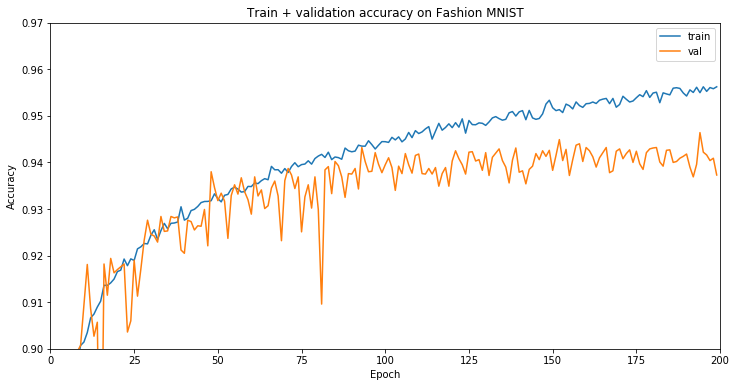

In [126]:
plot_history_acc(history, ylims=[0.9, 0.97], xlims=[0, 200])

In [118]:
net.load_state_dict(last_model_wts)

In [88]:
def get_lr(opt):
    return opt.state_dict()['param_groups'][0]['lr']


lr = get_lr(optimizer)
print(lr)

1.0


In [119]:
model, history2 = train_model(
    net, criterion, optimizer, scheduler=None, num_epochs=40)

Epoch 1/40
----------
train Loss: 0.1193 Acc: 0.9569
val Loss: 0.1718 Acc: 0.9465

Epoch 2/40
----------
train Loss: 0.1194 Acc: 0.9569
val Loss: 0.1729 Acc: 0.9447

Epoch 3/40
----------
train Loss: 0.1205 Acc: 0.9563
val Loss: 0.1674 Acc: 0.9473

Epoch 4/40
----------
train Loss: 0.1219 Acc: 0.9549
val Loss: 0.1825 Acc: 0.9438

Epoch 5/40
----------
train Loss: 0.1200 Acc: 0.9568
val Loss: 0.1673 Acc: 0.9447

Epoch 6/40
----------
train Loss: 0.1200 Acc: 0.9559
val Loss: 0.1763 Acc: 0.9456

Epoch 7/40
----------
train Loss: 0.1204 Acc: 0.9564
val Loss: 0.1801 Acc: 0.9442

Epoch 8/40
----------
train Loss: 0.1182 Acc: 0.9565
val Loss: 0.1793 Acc: 0.9461

Epoch 9/40
----------
train Loss: 0.1180 Acc: 0.9575
val Loss: 0.1830 Acc: 0.9418

Epoch 10/40
----------
train Loss: 0.1183 Acc: 0.9571
val Loss: 0.1738 Acc: 0.9444

Epoch 11/40
----------
train Loss: 0.1156 Acc: 0.9585
val Loss: 0.1760 Acc: 0.9445

Epoch 12/40
----------
train Loss: 0.1177 Acc: 0.9560
val Loss: 0.1795 Acc: 0.9444

E

ValueError: too many values to unpack (expected 2)

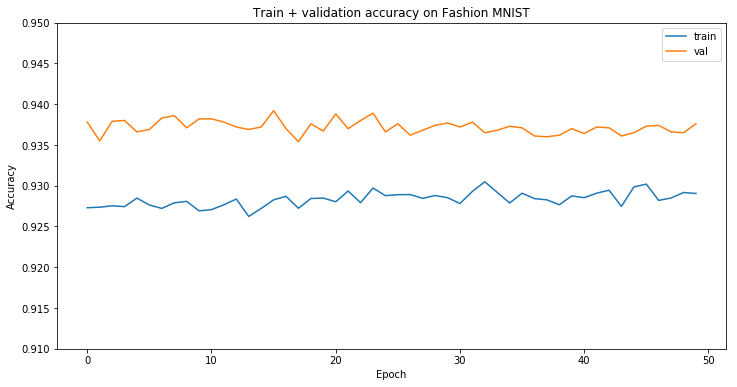

In [120]:
plot_history_acc(history2, ylims=[0.91, 0.95])

In [97]:
adadelta = optim.Adadelta(model.parameters())

In [98]:
model, history3 = train_model(
    model, criterion, adadelta, scheduler=None, num_epochs=20)

Epoch 1/20
----------
train Loss: 0.4009 Acc: 0.8607
val Loss: 0.3386 Acc: 0.8762

Epoch 2/20
----------
train Loss: 0.3324 Acc: 0.8834
val Loss: 0.2849 Acc: 0.9001

Epoch 3/20
----------
train Loss: 0.3035 Acc: 0.8921
val Loss: 0.2895 Acc: 0.8950

Epoch 4/20
----------
train Loss: 0.2848 Acc: 0.8994
val Loss: 0.2637 Acc: 0.9066

Epoch 5/20
----------
train Loss: 0.2805 Acc: 0.9017
val Loss: 0.2493 Acc: 0.9109

Epoch 6/20
----------
train Loss: 0.2651 Acc: 0.9067
val Loss: 0.2478 Acc: 0.9111

Epoch 7/20
----------
train Loss: 0.2561 Acc: 0.9094
val Loss: 0.2444 Acc: 0.9094

Epoch 8/20
----------
train Loss: 0.2484 Acc: 0.9119
val Loss: 0.2507 Acc: 0.9088

Epoch 9/20
----------
train Loss: 0.2424 Acc: 0.9148
val Loss: 0.2434 Acc: 0.9147

Epoch 10/20
----------
train Loss: 0.2359 Acc: 0.9167
val Loss: 0.2787 Acc: 0.9018

Epoch 11/20
----------
train Loss: 0.2348 Acc: 0.9164
val Loss: 0.2195 Acc: 0.9213

Epoch 12/20
----------
train Loss: 0.2267 Acc: 0.9207
val Loss: 0.2301 Acc: 0.9194

E

# Some interesting observations

* Batch sizes matter: but be careful about memory issues
    * Reducing *batch_size* from 16 to 8 has a negative effect on training.
    * Increasing *batch_size* from 16 to 32 helps performance, but further increasing the size to 50 does not seem helpful. There might be a local optimum around 32.
* Dropout matters
    * The architecture can be very sensitive to where dropout layers are placed.
    * Dropout on the fully connected layers seems to work better, but that alone cannot completely mitigate overfitting.
* The exact normalization procedure (seems) irrelevant with respect to performance
    * (0,1) $\rightarrow$ (-1, 1)

* Size matters
    * The size of the convolutional layers is important; increasing the number of filters helps the system learn better representations, it seems.
    
* Peak performance on validation set: $93.58%$ accuracy using *batch_size* = 32 and *num_epochs* = 140

In [42]:
def plot_lr(lr_min, lr_max, T_period):
    xx = np.linspace(0, 149, 150)
    yy = lr_min + 0.5 * (lr_max - lr_min) * (
        1.0 + np.cos(xx / (T_period / 2.0) * np.pi))
    plt.figure(figsize=(9, 9))
    plt.plot(xx, yy)
    plt.show()

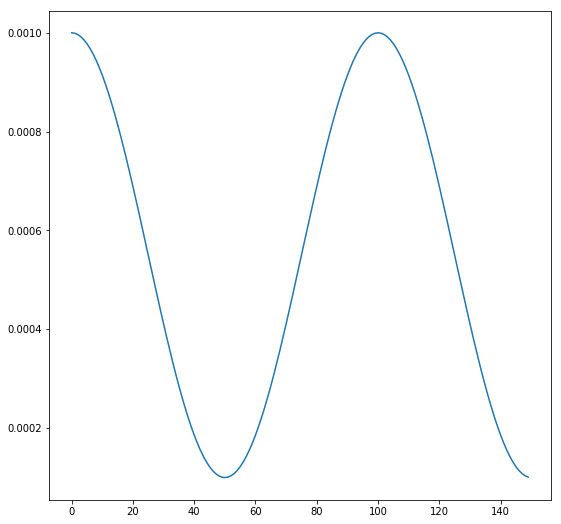

In [43]:
plot_lr(1e-4, 1e-3, 100)

# End of notebook